## Trawl Region Glorys Timeseries Processing

This notebook processes timeseries of surface and bottom conditions for reference/use in other projects. The regions used are the sub-regions of the trawl strata we frequently work with, and the ecological production units as well.

In [3]:
####  Libraries  ####
import xarray as xr
import dask
import os
import numpy as np
import geopandas as gpd
import regionmask
import re

# Paths to resources
box_path = "/Users/adamkemberling/Library/CloudStorage/Box-Box/"
trawl_path = f"{box_path}RES_Data/Shapefiles/nmfs_trawl_regions/"
epu_path = f"{box_path}RES_Data/Shapefiles/EPU/individual_epus/"
glorys_path = f"{box_path}RES_Data/GLORYs/NE_Shelf_TempSal/"

<Axes: >

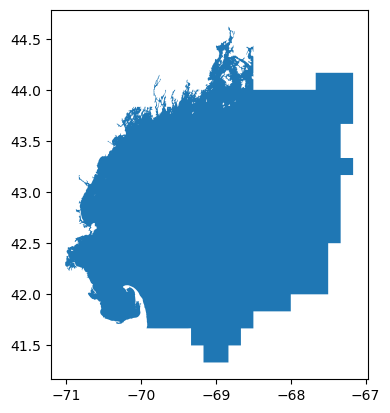

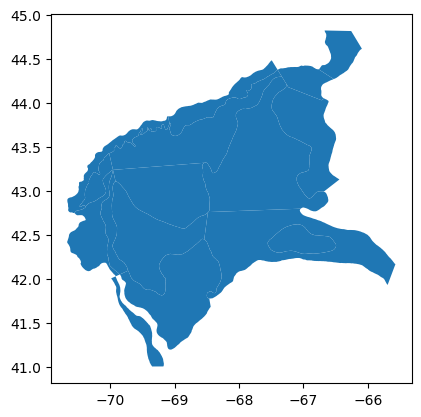

In [ ]:
# Load Shapefiles into Lists
import glob

# Load EPU Polygons
epu_areas = glob.glob(f"{epu_path}*.geojson")
epu_names = []
epu_polys = []
for area in epu_areas:
    epu_names.append(area.removesuffix(".geojson").removeprefix(f"{epu_path}"))
    epu_polys.append(gpd.read_file(f"{area}"))


# Load Trawl Strata-Regions
trawl_areas = glob.glob(f"{trawl_path}*.geojson")
trawl_names = []
trawl_polys = []
for area in trawl_areas:
    trawl_names.append(area.removesuffix(".geojson").removeprefix(f"{trawl_path}nmfs_trawl_"))
    trawl_polys.append(gpd.read_file(f"{area}"))


# Convert lists to dictionary
epu_poly_dict = {epu_names[i]: epu_polys[i] for i in range(len(epu_names))}
trawl_poly_dict = {trawl_names[i]: trawl_polys[i] for i in range(len(trawl_names))}
    

# Plot epu
epu_poly_dict["GOM"].plot()

# # Plot trawl
trawl_poly_dict["gulf_of_maine"].plot()

## Load Surface and Bottom Temperature Data

Surface and bottom temperatures were processed into a standalone dataset in `LOBECOL_SurfBot_Temp_Processing.ipynb`. We can load that and skip the bottom layer mumbo jumbo.

In [18]:
# Save destination file structure
surfbot_path = "../GLORYS_surfbot_temps/"
# surfbot_path

# # Get file paths
fpaths_glorys = os.listdir(surfbot_path)


# File paths, no ds_store
# Pattern matching for .nc only
pattern = r".*\.nc$"  # Match all files ending with ".nc"

# list the .nc files
fpaths_glorys = []
for filename in os.listdir(surfbot_path):
    if re.search(pattern, filename):
        fpaths_glorys.append(f"{surfbot_path}{filename}")


# Check files are there
fpaths_glorys[0:6]

# Open one file to get depth indices
glorys_surfbot = xr.open_mfdataset(fpaths_glorys, combine = "by_coords", parallel = True)
glorys_surfbot


<xarray.Dataset> Size: 7GB
Dimensions:       (time: 11618, latitude: 132, longitude: 226)
Coordinates:
  * time          (time) datetime64[ns] 93kB 1993-01-01 ... 2024-10-22
  * latitude      (latitude) float32 528B 35.25 35.33 35.42 ... 46.0 46.08 46.17
  * longitude     (longitude) float32 904B -75.67 -75.58 -75.5 ... -57.0 -56.92
Data variables:
    bottom_temp   (time, latitude, longitude) float64 3GB dask.array<chunksize=(365, 132, 226), meta=np.ndarray>
    bottom_depth  (time, latitude, longitude) float32 1GB dask.array<chunksize=(365, 132, 226), meta=np.ndarray>
    surface_temp  (time, latitude, longitude) float64 3GB dask.array<chunksize=(365, 132, 226), meta=np.ndarray>

# Cropping Area-of-interest Timeseries

From here we can loop through the different areas and mask out their values. 

The following function will perform regional masking of an xarray dataset for a target variable, returning a pandas dataframe.

In [19]:
# Function to mask
def calc_ts_mask(grid_obj, shp_obj, shp_name, var_name = "sst"):
  """
  Return a timeseries using data that falls within shapefile. 
  
  Standard deviation
  not included so that this function can be used for any period of time.
  
  Args:
    grid_obj       : xr.Dataset of the desired input data to mask
    shp_obj        : shapefile polygon to use as a mask
    shp_name (str) : String to use as name when making mask
    var_name (str) : Optional string identifying the variable to use
    climatology (bool): Whether you are masking a climatology, informs naming conventions and
    whether to process standard deviation
  """

  #### 1. Make the mask
  area_mask = regionmask.Regions(
    shp_obj.geometry,
    name = shp_name)

  #### 2. Mask the array with gom_mask to get nan test
  # mask = area_mask.mask(grid_obj, lon_name = "longitude", lat_name = "latitude")
  mask = area_mask.mask(grid_obj["longitude"], grid_obj["latitude"])

  #### 3. Extract data that falls within the mask
  masked_ds = grid_obj.where(~np.isnan(mask))

  #### 4. Calculate timeseries mean

  # Not area-weighted
  masked_ts = getattr(masked_ds, var_name).mean(dim = ("latitude", "longitude"))

  #### 5. Change time index rownames to a column 

  # Convert to Timeseries Dataframe
  masked_ts_df = masked_ts.to_dataframe()
  masked_ts_df = masked_ts_df.reset_index()[["time", f"{var_name}"]]
    
  # Return the table as output
  return masked_ts_df

## Perform Masking on epu/trawl Areas

The following code will loop through the regions and process regional means of surface and bottom temperatures.

In [20]:
# list to store the epu region timeseries
epu_ts = []  # epu area timeseries

# Iterate through names and shapes simultaneously


############  EPUS  ###########
for mask_shp, mask_name in zip(epu_polys, epu_names):
    
    #### 1. Get masked Timeseries of surface temperature
    masked_sst = calc_ts_mask(
        grid_obj = glorys_surfbot, 
        shp_obj  = mask_shp, 
        shp_name = mask_name,
        var_name = "surface_temp")

    #### 2. Get masked Timeseries of bottom temperature
    masked_bt = calc_ts_mask(
        grid_obj = glorys_surfbot, 
        shp_obj  = mask_shp, 
        shp_name = mask_name,
        var_name = "bottom_temp")
    
    #### 3. Merge on time
    
    # Merge
    regional_timeline = masked_sst.merge(masked_bt, how = "left", on = "time")

    #Set index as the date, drop time
    regional_timeline.index = regional_timeline.index = regional_timeline["time"]
    regional_timeline       = regional_timeline.drop(["time"], axis = 1)

    # Reset Index
    regional_timeline = regional_timeline.reset_index()
    
    # Add to list
    epu_ts.append(regional_timeline)
    
    print(f"{mask_name} timeseries processed.")


########### Trawl Regions  #########
# list to store the trawl region timeseries
trawl_ts = []  

# Iterate through names and shapes simultaneously
for mask_shp, mask_name in zip(trawl_polys, trawl_names):
    
    #### 1. Get masked Timeseries of surface temperature
    masked_sst = calc_ts_mask(
        grid_obj = glorys_surfbot, 
        shp_obj  = mask_shp, 
        shp_name = mask_name,
        var_name = "surface_temp")

    #### 2. Get masked Timeseries of bottom temperature
    masked_bt = calc_ts_mask(
        grid_obj = glorys_surfbot, 
        shp_obj  = mask_shp, 
        shp_name = mask_name,
        var_name = "bottom_temp")
    
    
    #### 3. Merge on time
    
    # Merge
    regional_timeline = masked_sst.merge(masked_bt, how = "left", on = "time")

    #Set index as the date, drop time
    regional_timeline.index = regional_timeline.index = regional_timeline["time"]
    regional_timeline       = regional_timeline.drop(["time"], axis = 1)

    # # Reset Index
    regional_timeline = regional_timeline.reset_index()
    
    # Add to list
    trawl_ts.append(regional_timeline)
    
    print(f"{mask_name} timeseries processed.")

GB timeseries processed.
SS timeseries processed.
MAB timeseries processed.
GOM timeseries processed.
regions_collection timeseries processed.
inuse_strata timeseries processed.
gulf_of_maine timeseries processed.
southern_new_england timeseries processed.
georges_bank timeseries processed.
mid_atlantic_bight timeseries processed.


In [21]:
# Check one
print(epu_names[3])
epu_ts[3].head()

GOM


,time,surface_temp,bottom_temp
0,1993-01-01,6.290488,7.167609
1,1993-01-02,6.221390,7.156395
2,1993-01-03,6.125108,7.135329
3,1993-01-04,6.144460,7.145155
4,1993-01-05,6.247637,7.179939


<Axes: xlabel='time'>

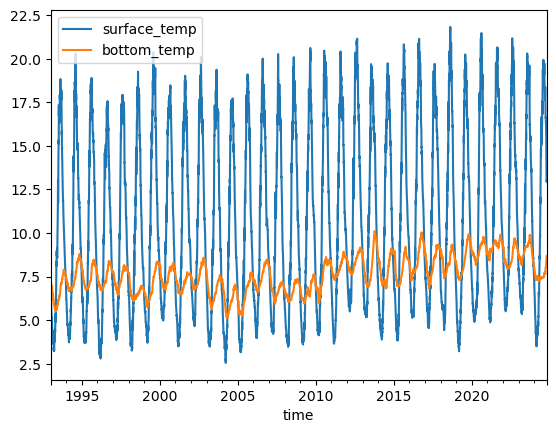

In [22]:
epu_ts[3].plot("time")

<Axes: xlabel='time'>

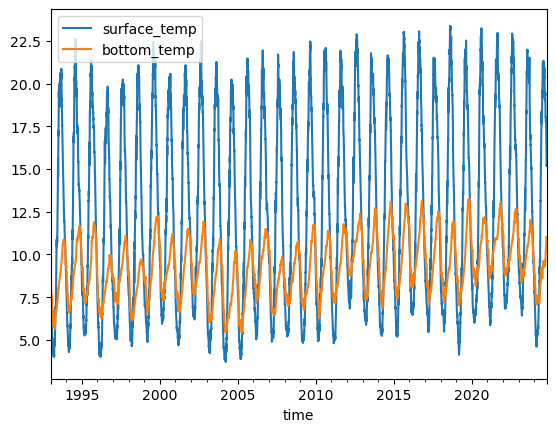

In [23]:
trawl_ts[0].plot("time")

In [26]:
# Save epu timeseres

glorys_path_out = f"{box_path}RES_Data/GLORYs/Trawl_EPU_surfbot_timeseries/"

# Save epu timeseres
for region_ts, region_name in zip(epu_ts, epu_names):
    region_ts.to_csv(f"{glorys_path_out}GLORYs_surfbottemp_{region_name}_EPU.csv")


# Save trawl timeseries
for region_ts, region_name in zip(trawl_ts, trawl_names):
    region_ts.to_csv(f"{glorys_path_out}GLORYs_surfbottemp_{region_name}_strata.csv")